# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data Collection](#data-collection)
* [Data Analysis](#data-anaysis)
* [Results](#results)

## Introduction: Business Problem <a name="introduction"></a>

The main goal of this project is to define where the best place is in Vancouver (Canada) to open a new restaurant specialized in Mediterranean cuisine. In order to answer this question, we will analyze the venues of Vancouver and get all the information about the restaurants that currently exist in Vancouver. To approach the project, we will use the Foursquare API, which will help us in collecting the information such as tips, restaurant's category and more. This will let us to know which is the most common category of restaurants, so we will know if there are more popular restaurants than others. Finally, we will know if it is viable to open the restaurant or not depending on the analysis. The most important task is to detect potential competitors.

**Main goal**

Search for business opportunities starting with the opening of a new Mediterranean cuisine restaurant in Vancouver.

**Target Audience**

The following target populations would be potential clients: students, tourists, workers, families.

Based on definition of our problem, factors that will influence our decision are:
* number of existing restaurants in the neighborhood (any type of restaurant)
* type of restaurants in the neighborhood

Following data sources will be needed to extract/generate the required information:
* Number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**.
* Coordinate of different locations in Vancouver will be obtained using **Nominatim Software**.
* Vancouver postal codes from Wikipedia: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_T (only those from "Vancouver").

---

## Data Collection <a name="data-collection"></a>

In [1]:
!pip install folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
from bs4 import BeautifulSoup
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None  # default='warn'

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [3]:
data_info = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_V")
soup = BeautifulSoup(data_info.text, 'html5lib')

In [4]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if "Vancouver" not in row.span.text:
        pass
    else:
        cell['PostalCode'] = row.b.text[:3]
        cell['Borough'] = (row.span.a.text).split('(')[0]
        my_string = row.span.a.text
        cell['Neighborhood'] = (((((row.span.text).split(my_string)[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip('( ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)

In [5]:
df.shape

(44, 3)

In [6]:
df['Latitude'] = 0.0
df['Longitude'] = 0.0

In [7]:
for index, row in df.iterrows():
    address = (str([i for i in row['Neighborhood'].split(',')][0]), str(row['Borough']))
    
    geolocator = Nominatim(user_agent="vancouver_explorer")
    location = geolocator.geocode(address)
    if(location is not None):
        latitude = location.latitude
        df['Latitude'][index] = latitude
        longitude = location.longitude
        df['Longitude'][index] = longitude

In [8]:
df = df[df["Latitude"] != 0.0]
df.drop_duplicates(subset ="Latitude", keep = False, inplace = True)
df = df.reset_index(drop=True)
df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,V6A,Vancouver,"Strathcona, Chinatown, Downtown Eastside",49.277693,-123.088539
1,V6C,Vancouver,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279
2,V6E,Vancouver,"SE West End, Davie Village",49.285062,-123.123060
3,V6G,Vancouver,"NW West End, Stanley Park",49.284131,-123.131795
4,V7G,North Vancouver,Outer East,52.350956,-128.504415
5,V6H,Vancouver,"West Fairview, Granville Island, NE Shaughnessy",49.261956,-123.130408
6,V5K,Vancouver,North Hastings-Sunrise,49.270644,-123.025786
7,V5L,Vancouver,North Grandview-Woodland,49.276859,-123.072584
8,V6L,Vancouver,"NW Arbutus Ridge, NE Dunbar-Southlands",49.253758,-123.154789
9,V5R,Vancouver,South Renfrew-Collingwood,49.246551,-123.047349


In [9]:
df.shape

(17, 5)

In [10]:
geolocator = Nominatim(user_agent="vancouver_explorer")
location = geolocator.geocode("Vancouver, Canada")
latitude = location.latitude
longitude = location.longitude
vancouver_map = folium.Map(location=[latitude, longitude], zoom_start=12)
vancouver_map

In [11]:
# create map of New York using latitude and longitude values
vancouver_map = folium.Map(location=[latitude, longitude], zoom_start=6)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(vancouver_map)  
    
vancouver_map

In [12]:
CLIENT_ID = 'WXDDCYBSUHBDMYUR0RVZGAP3N450CE443MAOXJXUFCSI40LI' # your Foursquare ID
CLIENT_SECRET = 'VL302DLWYYPSVYQROKFONGDNO4IE1ZMXZ25FT4CTS4S51R1M' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WXDDCYBSUHBDMYUR0RVZGAP3N450CE443MAOXJXUFCSI40LI
CLIENT_SECRET:VL302DLWYYPSVYQROKFONGDNO4IE1ZMXZ25FT4CTS4S51R1M


In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
vancouver_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Strathcona, Chinatown, Downtown Eastside
Waterfront, Coal Harbour, Canada Place
SE West End, Davie Village
NW West End, Stanley Park
Outer East
West Fairview, Granville Island, NE Shaughnessy
North Hastings-Sunrise
North Grandview-Woodland
NW Arbutus Ridge, NE Dunbar-Southlands
South Renfrew-Collingwood
Killarney
NW Dunbar-Southlands, Chaldecutt, South University Endowment Lands
UBC
SE Oakridge, East Marpole, South Sunset
Bentall Centre
Pacific Centre
East Fairview, South Cambie


In [15]:
vancouver_venues.shape

(519, 7)

In [16]:
vancouver_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Strathcona, Chinatown, Downtown Eastside",49.277693,-123.088539,Union Market,49.277371,-123.086989,Deli / Bodega
1,"Strathcona, Chinatown, Downtown Eastside",49.277693,-123.088539,MacLean Park,49.278809,-123.088546,Park
2,"Strathcona, Chinatown, Downtown Eastside",49.277693,-123.088539,Strathcona Park,49.275183,-123.084919,Park
3,"Strathcona, Chinatown, Downtown Eastside",49.277693,-123.088539,Wilder Snail,49.279346,-123.087338,Coffee Shop
4,"Strathcona, Chinatown, Downtown Eastside",49.277693,-123.088539,Strathcona Beer Company,49.281294,-123.085111,Brewery
5,"Strathcona, Chinatown, Downtown Eastside",49.277693,-123.088539,Finch’s Market,49.278565,-123.093473,Sandwich Place
6,"Strathcona, Chinatown, Downtown Eastside",49.277693,-123.088539,les amis du Fromage,49.281199,-123.086241,Cheese Shop
7,"Strathcona, Chinatown, Downtown Eastside",49.277693,-123.088539,The Juice Truck,49.281281,-123.092120,Food Truck
8,"Strathcona, Chinatown, Downtown Eastside",49.277693,-123.088539,The Heatley,49.281091,-123.089629,Restaurant
9,"Strathcona, Chinatown, Downtown Eastside",49.277693,-123.088539,Astoria Pub,49.281295,-123.087777,Pub


In [17]:
vancouver_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bentall Centre,75,75,75,75,75,75
"East Fairview, South Cambie",48,48,48,48,48,48
Killarney,17,17,17,17,17,17
"NW Arbutus Ridge, NE Dunbar-Southlands",5,5,5,5,5,5
"NW Dunbar-Southlands, Chaldecutt, South University Endowment Lands",7,7,7,7,7,7
"NW West End, Stanley Park",57,57,57,57,57,57
North Grandview-Woodland,41,41,41,41,41,41
North Hastings-Sunrise,6,6,6,6,6,6
Pacific Centre,14,14,14,14,14,14


## Data Analysis <a name="data-analysis"></a>

In [18]:
# one hot encoding
vancouver_onehot = pd.get_dummies(vancouver_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
vancouver_onehot['Neighborhood'] = vancouver_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [vancouver_onehot.columns[-1]] + list(vancouver_onehot.columns[:-1])
vancouver_onehot = vancouver_onehot[fixed_columns]

vancouver_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Boat or Ferry,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Cantonese Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cycle Studio,Deli / Bodega,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,Gift Shop,Greek Restaurant,Grocery Store,Gym,Hawaiian Restaurant,Health Food Store,Heliport,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Leather Goods Store,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Music Venue,Nail Salon,New American Restaurant,Noodle House,Office,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Physical Therapist,Pizza Place,Playground,Plaza,Poke Place,Pub,Ramen Restaurant,Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Soup Place,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio
0,"Strathcona, Chinatown, Downtown Eastside",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Strathcona, Chinatown, Downtown Eastside",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Strathcona, Chinatown, Downtown Eastside",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Strathcona, Chinatown, Downtown Eastside",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Strathcona, Chinatown, Downtown Eastside",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Get only venues filtering by the word "Restaurant"

In [19]:
restaurant_data = vancouver_venues[vancouver_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
restaurant_data

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Strathcona, Chinatown, Downtown Eastside",49.277693,-123.088539,The Heatley,49.281091,-123.089629,Restaurant
1,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Miku Restaurant,49.286713,-123.112044,Japanese Restaurant
2,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Pholicious,49.284309,-123.112290,Vietnamese Restaurant
3,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Pourhouse,49.284222,-123.108330,Restaurant
4,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Vegan Pudding & Co.,49.283873,-123.112336,Vegetarian / Vegan Restaurant
5,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Indigo Age,49.283566,-123.112699,Vegetarian / Vegan Restaurant
6,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Rogue Kitchen & Wetbar,49.285333,-123.111944,New American Restaurant
7,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Baghdad Cafe,49.283493,-123.114550,Middle Eastern Restaurant
8,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Nuba,49.282812,-123.109582,Middle Eastern Restaurant
9,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Scoozis,49.285858,-123.115225,Mediterranean Restaurant


## Get Restaurant's category

In [20]:
list(restaurant_data["Venue Category"].unique())


['Restaurant',
 'Japanese Restaurant',
 'Vietnamese Restaurant',
 'Vegetarian / Vegan Restaurant',
 'New American Restaurant',
 'Middle Eastern Restaurant',
 'Mediterranean Restaurant',
 'American Restaurant',
 'Falafel Restaurant',
 'Italian Restaurant',
 'Hawaiian Restaurant',
 'Seafood Restaurant',
 'Australian Restaurant',
 'French Restaurant',
 'Indian Restaurant',
 'Ramen Restaurant',
 'Sushi Restaurant',
 'South Indian Restaurant',
 'Greek Restaurant',
 'Malay Restaurant',
 'Mexican Restaurant',
 'Thai Restaurant',
 'Asian Restaurant',
 'Korean Restaurant',
 'Tapas Restaurant',
 'Cuban Restaurant',
 'Cajun / Creole Restaurant',
 'Chinese Restaurant',
 'Fast Food Restaurant',
 'Cantonese Restaurant']

In [21]:
restaurant_data.shape

(116, 7)

### Get number of restaurants per Neighborhood

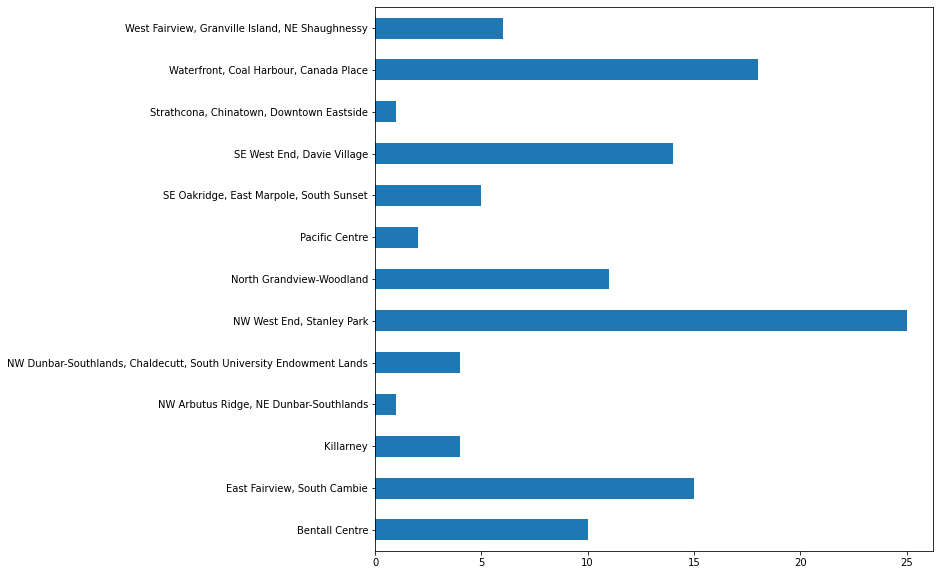

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10)) 
restaurants_neigh = (restaurant_data["Neighborhood"].value_counts().sort_index()).plot.barh()

### Get type of restaurants

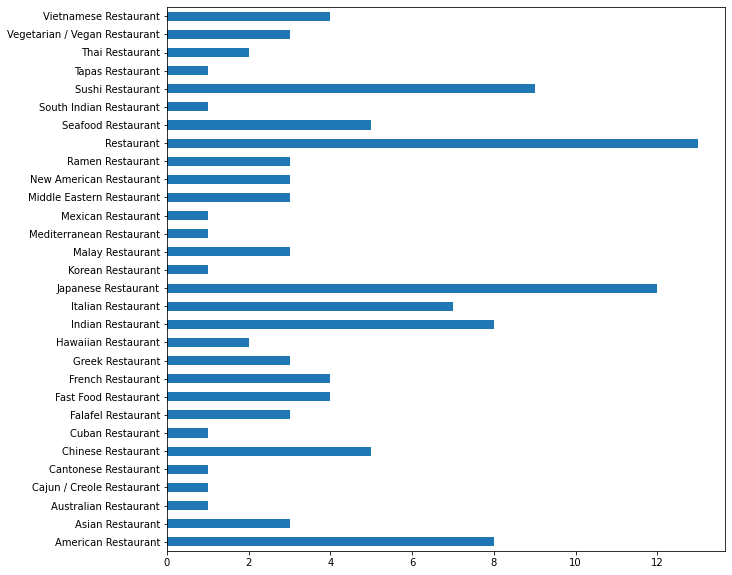

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10)) 
restaurants_neigh = (restaurant_data["Venue Category"].value_counts().sort_index()).plot.barh()

- We are going to filter the restaurants, first we will consider the category "Restaurant" as local restaurant, so it is not an international restaurant.
- We are going to remove Fast Food restaurants from our analysis

In [24]:
data_without_fastfood = restaurant_data[restaurant_data['Venue Category'] != 'Fast Food Restaurant']
international_restaurants = data_without_fastfood[data_without_fastfood['Venue Category'] != 'Restaurant']

In [25]:
international_restaurants["Neighborhood"].value_counts()

NW West End, Stanley Park                                             23
Waterfront, Coal Harbour, Canada Place                                15
East Fairview, South Cambie                                           13
SE West End, Davie Village                                            12
North Grandview-Woodland                                              11
Bentall Centre                                                         8
West Fairview, Granville Island, NE Shaughnessy                        5
NW Dunbar-Southlands, Chaldecutt, South University Endowment Lands     4
Killarney                                                              3
SE Oakridge, East Marpole, South Sunset                                3
Pacific Centre                                                         1
NW Arbutus Ridge, NE Dunbar-Southlands                                 1
Name: Neighborhood, dtype: int64

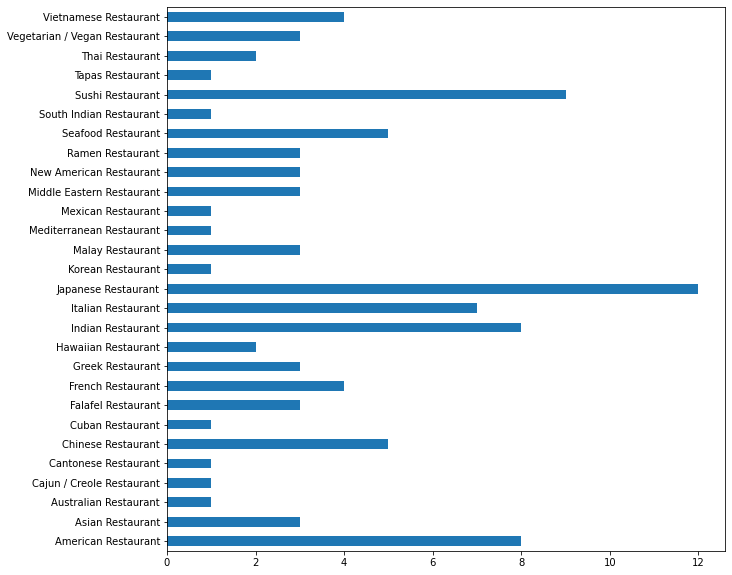

In [26]:
plt.figure(figsize=(10,10)) 
restaurants_international = (international_restaurants["Venue Category"].value_counts().sort_index()).plot.barh()

### Where are the current International restaurants?

- We will discard the Neighborhoods in which there are Mediterranean restaurants.
- We will discard the Neighborhoods in which there are Italian restaurants.

In [27]:
international_restaurants = international_restaurants[international_restaurants['Venue Category'] != 'Mediterranean Restaurant']
international_restaurants = international_restaurants[international_restaurants['Venue Category'] != 'Italian Restaurant']

international_restaurants = international_restaurants.reset_index(drop=True)
international_restaurants

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Miku Restaurant,49.286713,-123.112044,Japanese Restaurant
1,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Pholicious,49.284309,-123.112290,Vietnamese Restaurant
2,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Vegan Pudding & Co.,49.283873,-123.112336,Vegetarian / Vegan Restaurant
3,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Indigo Age,49.283566,-123.112699,Vegetarian / Vegan Restaurant
4,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Rogue Kitchen & Wetbar,49.285333,-123.111944,New American Restaurant
5,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Baghdad Cafe,49.283493,-123.114550,Middle Eastern Restaurant
6,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Nuba,49.282812,-123.109582,Middle Eastern Restaurant
7,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,The Flying Pig Gastown,49.283873,-123.106548,American Restaurant
8,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Koala Kebabs Donairs,49.283604,-123.113168,Falafel Restaurant
9,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Pokerrito,49.282739,-123.115057,Hawaiian Restaurant


In [28]:
international_restaurants.shape

(91, 7)

In [29]:
# create map of New York using latitude and longitude values
vancouver_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(international_restaurants['Venue Latitude'], international_restaurants['Venue Longitude'], international_restaurants['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(vancouver_map)  
    
vancouver_map

### Get the number of restaurants per Neighborhood with all filters applied

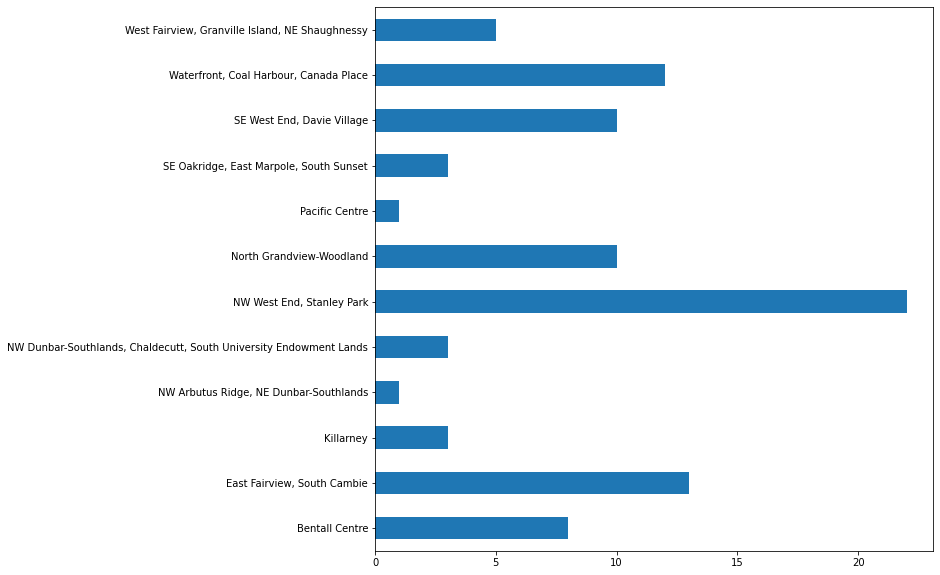

In [30]:
plt.figure(figsize=(10,10)) 
international_neigh = (international_restaurants["Neighborhood"].value_counts().sort_index()).plot.barh()

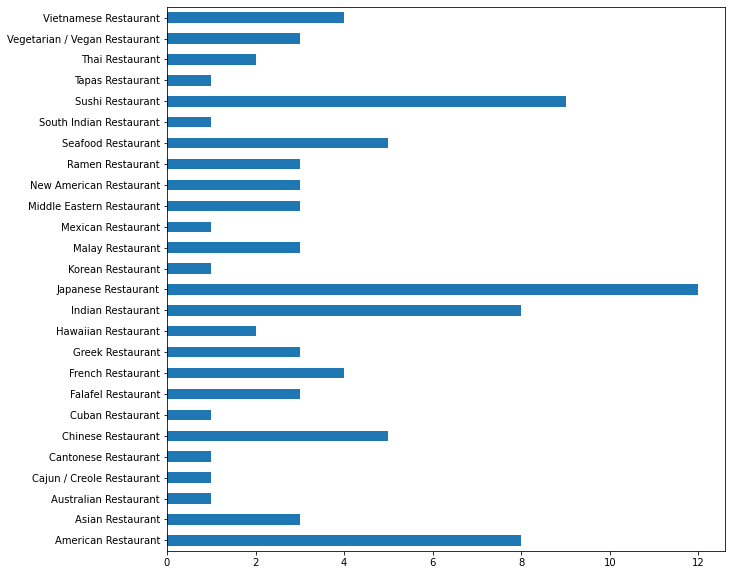

In [31]:
plt.figure(figsize=(10,10)) 
restaurants_international = (international_restaurants["Venue Category"].value_counts().sort_index()).plot.barh()

In [32]:
international_restaurants["Neighborhood"].value_counts().sort_index()

Bentall Centre                                                         8
East Fairview, South Cambie                                           13
Killarney                                                              3
NW Arbutus Ridge, NE Dunbar-Southlands                                 1
NW Dunbar-Southlands, Chaldecutt, South University Endowment Lands     3
NW West End, Stanley Park                                             22
North Grandview-Woodland                                              10
Pacific Centre                                                         1
SE Oakridge, East Marpole, South Sunset                                3
SE West End, Davie Village                                            10
Waterfront, Coal Harbour, Canada Place                                12
West Fairview, Granville Island, NE Shaughnessy                        5
Name: Neighborhood, dtype: int64

### Segment the number of restaurants per number of neighborhoods

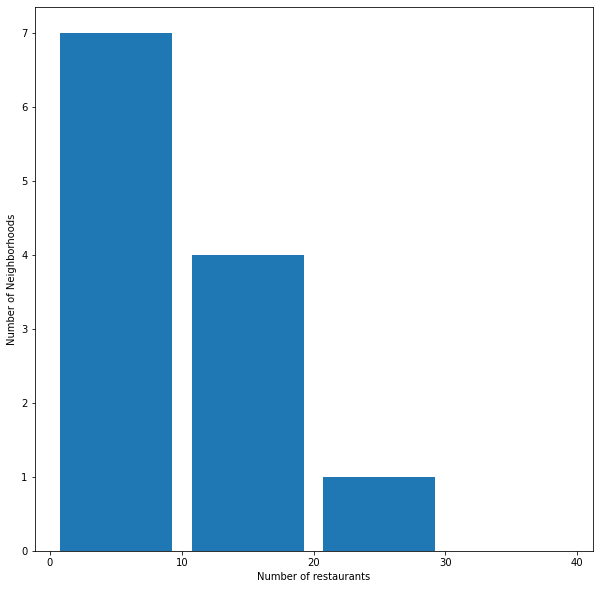

In [33]:
import matplotlib.pyplot as plt
intervals = [0, 10, 20, 30,40]
plt.figure(figsize=(10,10)) 

plt.hist(x=international_restaurants["Neighborhood"].value_counts(), bins=intervals, rwidth=0.85,)
plt.xlabel('Number of restaurants')
plt.ylabel('Number of Neighborhoods')
plt.xticks(intervals)

plt.show()

### Getting potential locations

From the histogram, we will select a Neighborhoods located in the second interval. These are the neighborhoods with more than 10 restaurants but less than 20 restaurants.

That's because we don't want to have a lot of competence, but we don't want to locate our new restaurant in a zone where the restaurants are not popular.

#### Number of restaurants per neighborhood

In [34]:
numberOfRestFilter = (international_restaurants['Neighborhood'].value_counts() <= 20) & (international_restaurants['Neighborhood'].value_counts() >= 10)
potential_locations = international_restaurants.groupby('Neighborhood').count()
potential_locations['In interval'] = numberOfRestFilter
potential_locations = potential_locations[potential_locations['In interval'] != False]
potential_locations


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,In interval
Neighborhood,,,,,,,
"East Fairview, South Cambie",13,13,13,13,13,13,True
North Grandview-Woodland,10,10,10,10,10,10,True
"SE West End, Davie Village",10,10,10,10,10,10,True
"Waterfront, Coal Harbour, Canada Place",12,12,12,12,12,12,True


### Only list the restaurants in the filtered neighborhoods

In [35]:
international_restaurants = international_restaurants[(international_restaurants['Neighborhood'] == 'East Fairview, South Cambie') | (international_restaurants['Neighborhood'] == 'North Grandview-Woodland') | (international_restaurants['Neighborhood'] == 'SE West End, Davie Village') | (international_restaurants['Neighborhood'] == 'Waterfront, Coal Harbour, Canada Place')]
international_restaurants.reset_index(drop=True)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Miku Restaurant,49.286713,-123.112044,Japanese Restaurant
1,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Pholicious,49.284309,-123.112290,Vietnamese Restaurant
2,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Vegan Pudding & Co.,49.283873,-123.112336,Vegetarian / Vegan Restaurant
3,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Indigo Age,49.283566,-123.112699,Vegetarian / Vegan Restaurant
4,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Rogue Kitchen & Wetbar,49.285333,-123.111944,New American Restaurant
5,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Baghdad Cafe,49.283493,-123.114550,Middle Eastern Restaurant
6,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Nuba,49.282812,-123.109582,Middle Eastern Restaurant
7,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,The Flying Pig Gastown,49.283873,-123.106548,American Restaurant
8,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Koala Kebabs Donairs,49.283604,-123.113168,Falafel Restaurant
9,"Waterfront, Coal Harbour, Canada Place",49.285950,-123.111279,Pokerrito,49.282739,-123.115057,Hawaiian Restaurant


### Most common restaurants per Neighborhood

In [36]:
# one hot encoding
vancouver_onehot2 = pd.get_dummies(international_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
vancouver_onehot2['Neighborhood'] = international_restaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [vancouver_onehot2.columns[-1]] + list(vancouver_onehot2.columns[:-1])
vancouver_onehot2 = vancouver_onehot2[fixed_columns]

In [37]:
vancouver_onehot2.shape

(45, 22)

In [38]:
vancouver_onehot2 = vancouver_onehot2.groupby('Neighborhood').sum()
vancouver_onehot2

,American Restaurant,Asian Restaurant,Australian Restaurant,Cajun / Creole Restaurant,Chinese Restaurant,Cuban Restaurant,Falafel Restaurant,French Restaurant,Hawaiian Restaurant,Indian Restaurant,Japanese Restaurant,Malay Restaurant,Middle Eastern Restaurant,New American Restaurant,Ramen Restaurant,Seafood Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"East Fairview, South Cambie",0,1,0,0,2,0,1,0,0,1,4,2,0,0,1,0,0,0,0,0,1
North Grandview-Woodland,0,1,0,1,0,1,0,1,0,2,0,0,0,0,0,0,1,1,1,1,0
"SE West End, Davie Village",2,0,0,0,0,0,0,2,0,1,2,0,0,1,0,2,0,0,0,0,0
"Waterfront, Coal Harbour, Canada Place",1,0,1,0,0,0,1,0,1,0,1,0,2,1,0,1,0,0,0,2,1


In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = vancouver_onehot2.index


for ind in np.arange(vancouver_onehot2.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vancouver_onehot2.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"East Fairview, South Cambie",Japanese Restaurant,Chinese Restaurant,Malay Restaurant,Ramen Restaurant,Falafel Restaurant
1,North Grandview-Woodland,Indian Restaurant,Asian Restaurant,French Restaurant,Thai Restaurant,Tapas Restaurant
2,"SE West End, Davie Village",Japanese Restaurant,Seafood Restaurant,French Restaurant,Indian Restaurant,New American Restaurant
3,"Waterfront, Coal Harbour, Canada Place",Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,New American Restaurant,Australian Restaurant


###  Representation of restaurants in each neighborhood

Markers of the restaursnts per Neighborhood

In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to the map
markers_colors = []
for index, lat, lon, name, poi in zip(
        international_restaurants.index,
        international_restaurants['Venue Latitude'], 
        international_restaurants['Venue Longitude'], 
        international_restaurants['Venue'], 
        international_restaurants['Neighborhood']):
    label = folium.Popup(str(index), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=name,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.8).add_to(map_clusters)

markers_colors = []
for index, lat, lon, poi in zip(
        international_restaurants.index,
        international_restaurants['Neighborhood Latitude'], 
        international_restaurants['Neighborhood Longitude'], 
        international_restaurants['Neighborhood']):
    label = folium.Popup(str(index), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=100,
        popup=poi,
        color="blue",
        fill=True,
        fill_opacity=0.02).add_to(map_clusters)
    
map_clusters

## Results <a name="results"></a>

The purpose of the analysis was to identify Vancouver areas close with mid number of restaurants in order to search an optimal location for a new Mediterranean restaurant.

By calculating restaurant density distribution from Foursquare data we have first identified neighborhoods without potential competitors that justify further analysis. Then generated collection of locations which satisfy some basic requirements regarding existing nearby restaurants. We located the restaurants in the areas with more possibilities based on: competetitors, number of restaurants and type of restaurant.

Based on the analysis we have four potential locations to open a new Mediterranean restaurant.

- East Fairview, South Cambie
- North Grandview-Woodland
- SE West End, Davie Village
- Waterfront, Coal Harbour, Canada Place

The first three neighborhoods have a very good chance of being a success zone for our restaurant. This is because restaurants in that areas specialize in Asian cuisine. Thus, we can look for other types of potential clients in the area.

In the last area, the most common restaurants tend to be more varied than in the previous areas. It is a good area, like *SE West End, Davie Village* because it is close to the airport and can be a good location to attract clients such as tourists.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), airport, schools, universities, proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.